# EXPLAINABLE AI Skin Cancer Detection explained with CAM Activations

In [1]:
# data config libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter

# display config libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# openCV
import cv2

# tensorflow and keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import custom packages and utility files

# data utility library
from DataUtility import SKIN_CANCER_TUMOR_TYPE
from DataUtility import dataUtils
skinDataUtils = dataUtils()

# model trainer library - reusable functions
from ModelTrainer import ModelTrainer
ModelTrainer = ModelTrainer()

# model validator - reusable functions
from ModelValidator import ValidateModel
ValidateSkinCancerClassfier = ValidateModel()

## Image Data Exploration

### 1. Malignant Images

<br>

***Samples of the malignant (cancerous) tumors...***

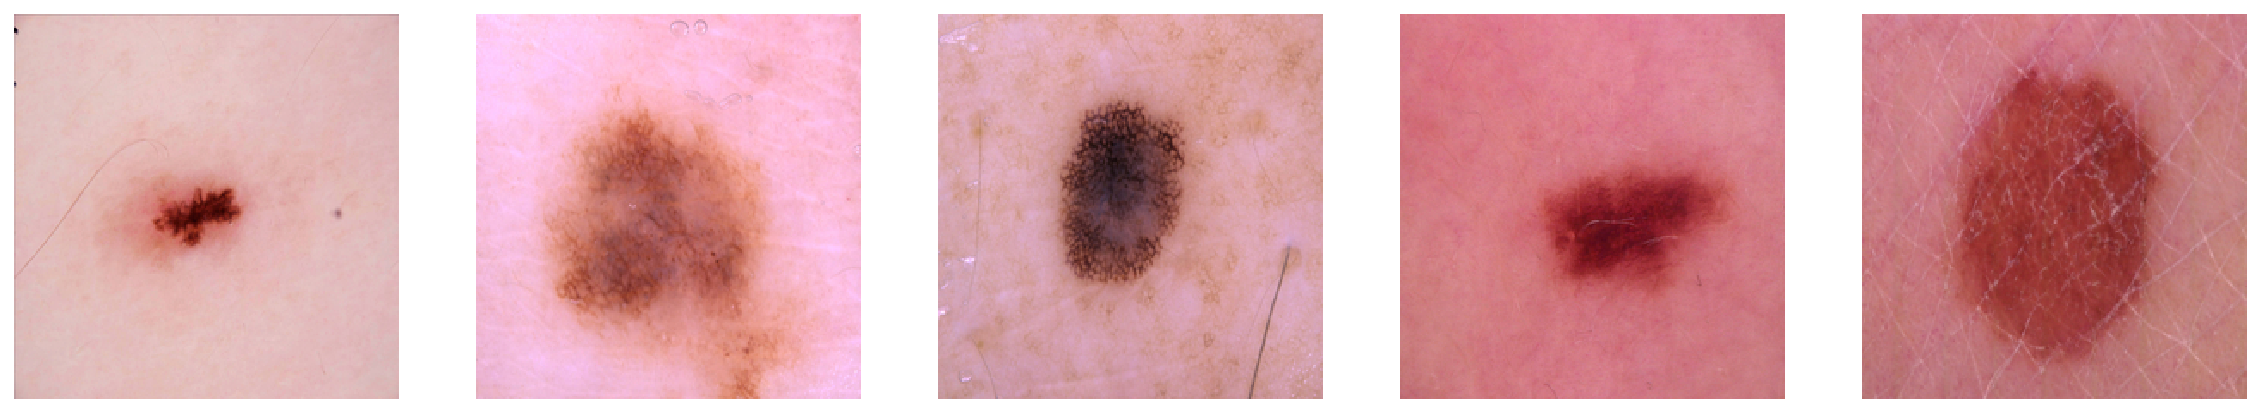

In [3]:
skinDataUtils.PrintMarkdownText('***Samples of the malignant (cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.BENIGN.value, 5)

### 2. Benign Images

<br>

***Samples of the benign (non-cancerous) tumors...***

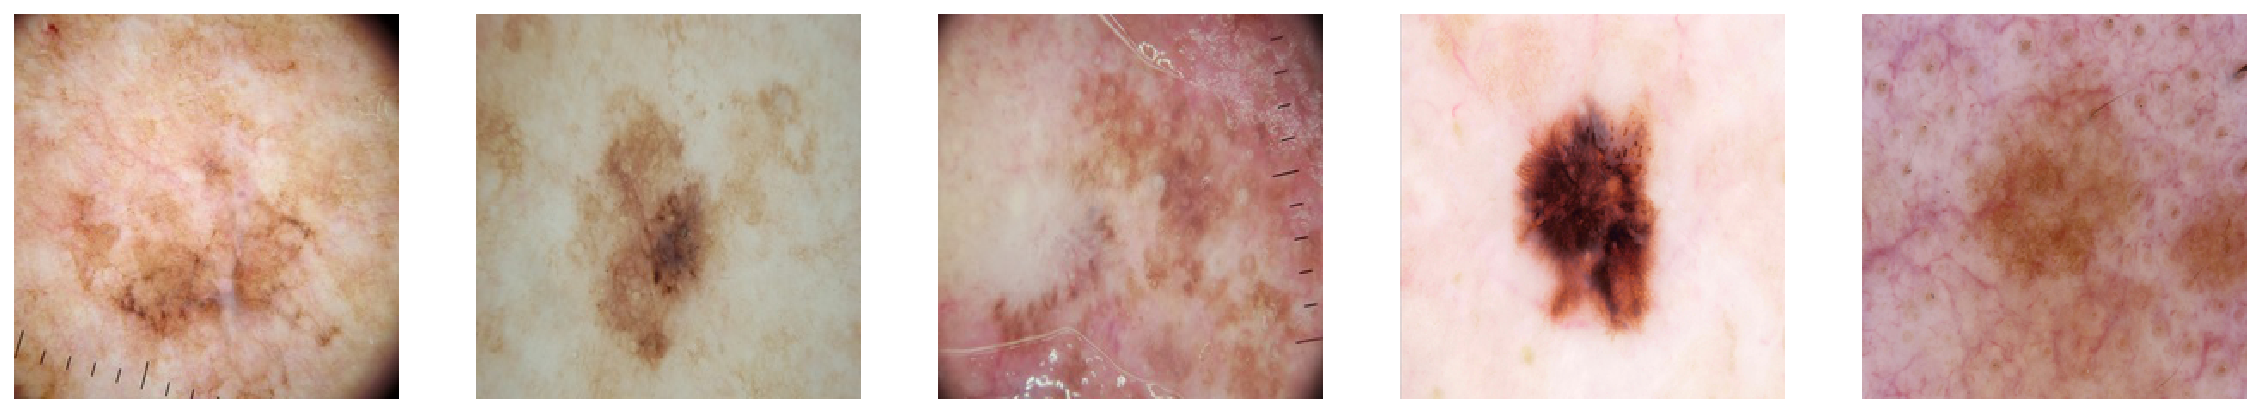

In [4]:
skinDataUtils.PrintMarkdownText('***Samples of the benign (non-cancerous) tumors...***')
skinDataUtils.ReadAndDisplayInputImages(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value, 5)

### Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Benign**

2. **Malignant**

***Malignant (cancerous)*** will be assigned values of 1 and ***Benign (non-cancerous)*** will be assigned the value 0.

In [5]:
skinCancer_df = skinDataUtils.GetLabelledSkinCancerData()

skinDataUtils.PrintMarkdownText('***Labelled skin cancer images...***')
skinCancer_df.head()

<br>

***Labelled skin cancer images...***

filename      label
0   ISIC Skin Cancer/images/malignant\507.jpg  Malignant
1  ISIC Skin Cancer/images/malignant\1465.jpg  Malignant
2      ISIC Skin Cancer/images/benign\820.jpg     Benign
3      ISIC Skin Cancer/images/benign\311.jpg     Benign
4  ISIC Skin Cancer/images/malignant\1068.jpg  Malignant

In [6]:
skinDataUtils.PrintMarkdownText('***Annotated skin cancer dataframe Info...***')
skinCancer_df.info()

<br>

***Annotated skin cancer dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3297 entries, 0 to 3296
Data columns (total 2 columns):
filename    3297 non-null object
label       3297 non-null object
dtypes: object(2)
memory usage: 51.6+ KB


<br>

***Sample Annotated Benign & Malignant Images...***

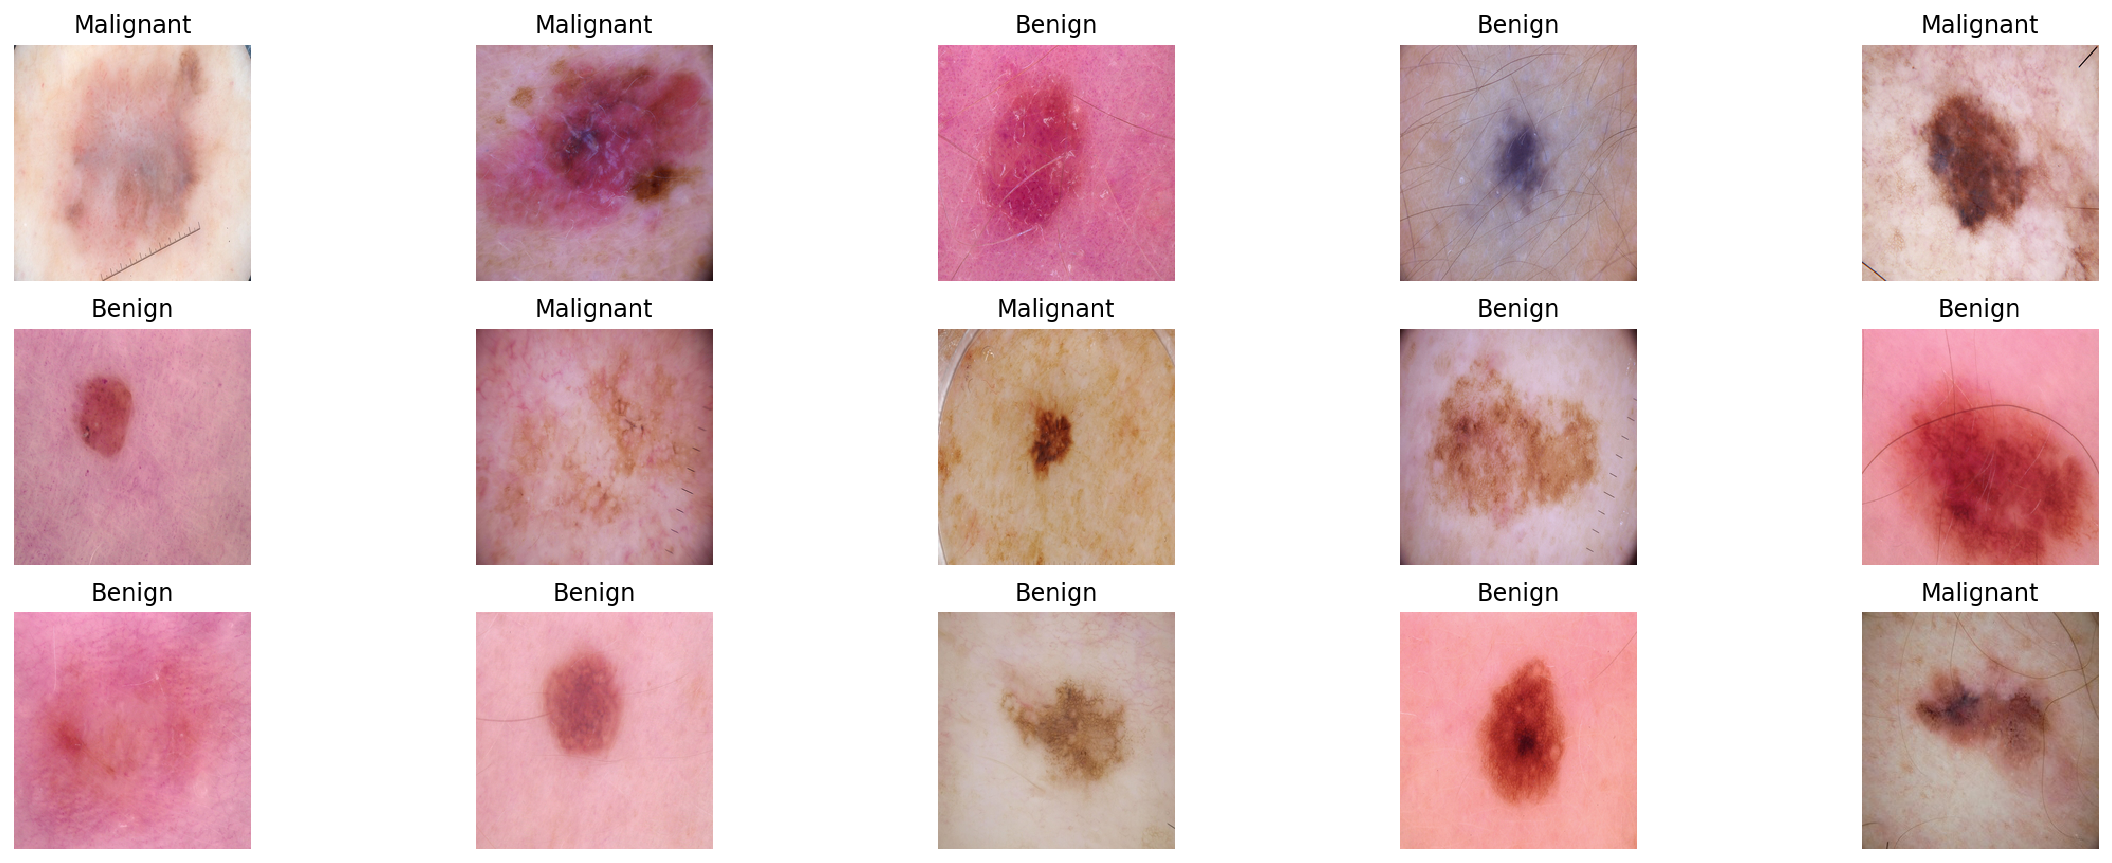

In [7]:
skinDataUtils.PrintMarkdownText('***Sample Annotated Benign & Malignant Images...***')
skinDataUtils.DisplayAnnotatedImages(skinCancer_df, 15)

## Image Dimensions

### 1. Malignant Images

In [8]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Malignant Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.MALIGNANT.value)

<br>

***Shape Distribution for Malignant Images:***

Counter({(224, 224, 3): 1497})

### 2. Benign Images

In [9]:
skinDataUtils.PrintMarkdownText('***Shape Distribution for Benign Images:***')
skinDataUtils.GetAllImageShape(SKIN_CANCER_TUMOR_TYPE.BENIGN.value)

<br>

***Shape Distribution for Benign Images:***

Counter({(224, 224, 3): 1800})

All the images are of uniform dimension --> **(224, 224, 3)**

## Test Train Validation Split

In [10]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(skinCancer_df['filename'].values,
                                                                      skinCancer_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [11]:
skinDataUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Validation Set Length: "  + str(len(validation_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 2521 samples
 -- Validation Set Length: 281 samples
 -- Test Set Length: 495 samples


In [12]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

skinDataUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'Benign': 1385, 'Malignant': 1136}) 

Validation Data: Counter({'Benign': 164, 'Malignant': 117}) 

Test Data: Counter({'Benign': 251, 'Malignant': 244})


##  Load All Images 
### Train, Test and Validation

In [13]:
# skinDataUtils.ReadAllImages
train_data = skinDataUtils.ReadAllImages(imageList = train_files, resizeImage = True, newImageSize = (135, 135))
validation_data = skinDataUtils.ReadAllImages(imageList = validation_files, resizeImage = True, newImageSize = (135, 135))
test_data = skinDataUtils.ReadAllImages(imageList = test_files, resizeImage = True, newImageSize = (135, 135))

In [14]:
# scale only the test data as train and validation 
# images will be rescaled in the image data generators.
X_test = test_data / 255.

### Label Encoding

Encode categorical values **(`'Benign' & 'Malingant'`)** to convert to the machine readable and interpretable values which would be **Benign - 0** and **Malignant - 1**.

In [15]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_validation = lbl_encoder.transform(validation_labels)
y_test = lbl_encoder.transform(test_labels)

skinDataUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Benign', 'Malignant', 'Benign', 'Malignant', 'Benign'] 

Encoded Train Labels:     [0 1 0 1 0]


## Model Training and Validation

In [16]:
# Training Parameters
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 30
INPUT_SHAPE = (135, 135, 3)

In [17]:
def BuildSkinCancerDetectionModel(INPUT_SHAPE = INPUT_SHAPE):

    model = Sequential(name = 'SkinCancerDetectionModel')

    model.add(Conv2D(32, (3,3), padding='same',input_shape = INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D(data_format='channels_last'))
    
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # metrics = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), 
    # keras.metrics.AUC(), keras.metrics.AUC(curve='PR')]

    print(model.summary())
    return model

In [18]:
skinCancerDetectModel = BuildSkinCancerDetectionModel()

Model: "SkinCancerDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 135, 135, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 135, 135, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 135, 135, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 67, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 67, 67, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 67, 67

In [19]:
CallBackList = ModelTrainer.GetCallBackList("SkinCancerDetectionModel")
ModelTrainer.PrintModelCallBacks(CallBackList)

Model Checkpoint (.h5 file) Path: ./SkinCancerDetectionModel.h5


<br>

***Model Callback List...***

1. <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x0000024D31069438>
2. <tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000024D31069D68>
3. <tensorflow.python.keras.callbacks.ReduceLROnPlateau object at 0x0000024D31069F60>


In [20]:
train_gen, val_gen = ModelTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [22]:
Model_Train_History = ModelTrainer.fit_generator(skinCancerDetectModel,
                                                 train_gen, 
                                                 EPOCHS, 
                                                 val_gen, 
                                                 CallBackList)

<br>

***Model Training Started...***

Epoch 1/30
78/78 [==============================] - 104s 1s/step - loss: 0.3344 - accuracy: 0.8429 - val_loss: 0.5763 - val_accuracy: 0.7227

Epoch 00001: val_loss did not improve from 0.39969
Epoch 2/30
78/78 [==============================] - 113s 1s/step - loss: 0.3357 - accuracy: 0.8405 - val_loss: 0.5660 - val_accuracy: 0.7188

Epoch 00002: val_loss did not improve from 0.39969
Epoch 3/30
78/78 [==============================] - 114s 1s/step - loss: 0.3260 - accuracy: 0.8441 - val_loss: 0.3426 - val_accuracy: 0.8242

Epoch 00003: val_loss improved from 0.39969 to 0.34263, saving model to .\SkinCancerDetectionModel.h5
Epoch 4/30
78/78 [==============================] - 110s 1s/step - loss: 0.3189 - accuracy: 0.8505 - val_loss: 0.3977 - val_accuracy: 0.8242

Epoch 00004: val_loss did not improve from 0.34263
Epoch 5/30
78/78 [==============================] - 109s 1s/step - loss: 0.3344 - accuracy: 0.8477 - val_loss: 0.5183 - val_accuracy: 0.7500

Epoch 00005: val_loss did not impro

In [ ]:
# skinCancerDetectModel = ValidateSkinCancerClassfier.load_model("models/SkinCancerDetectionModel.h5")

### Model Testing

In [23]:
y_preds_probability, y_preds_binary = ValidateSkinCancerClassfier.GetModelPredictions(skinCancerDetectModel, X_test)

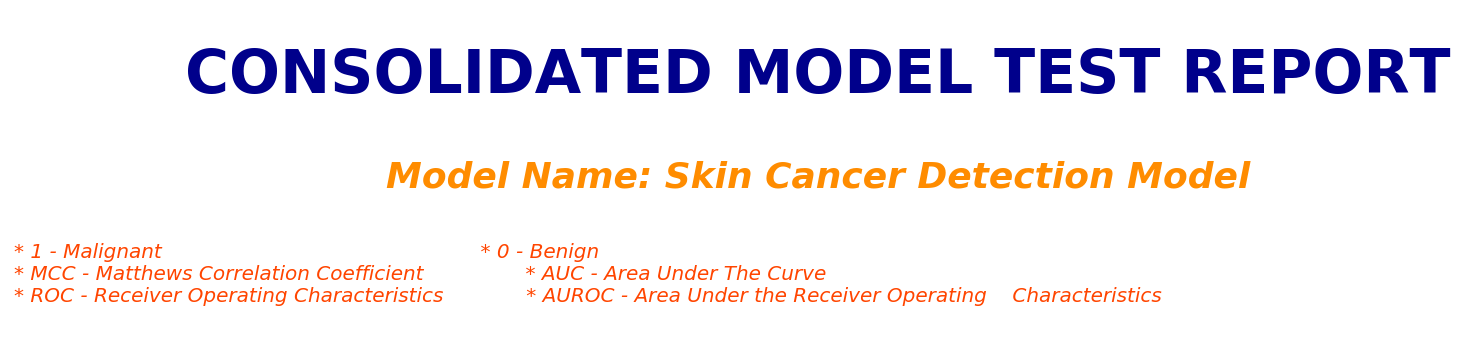

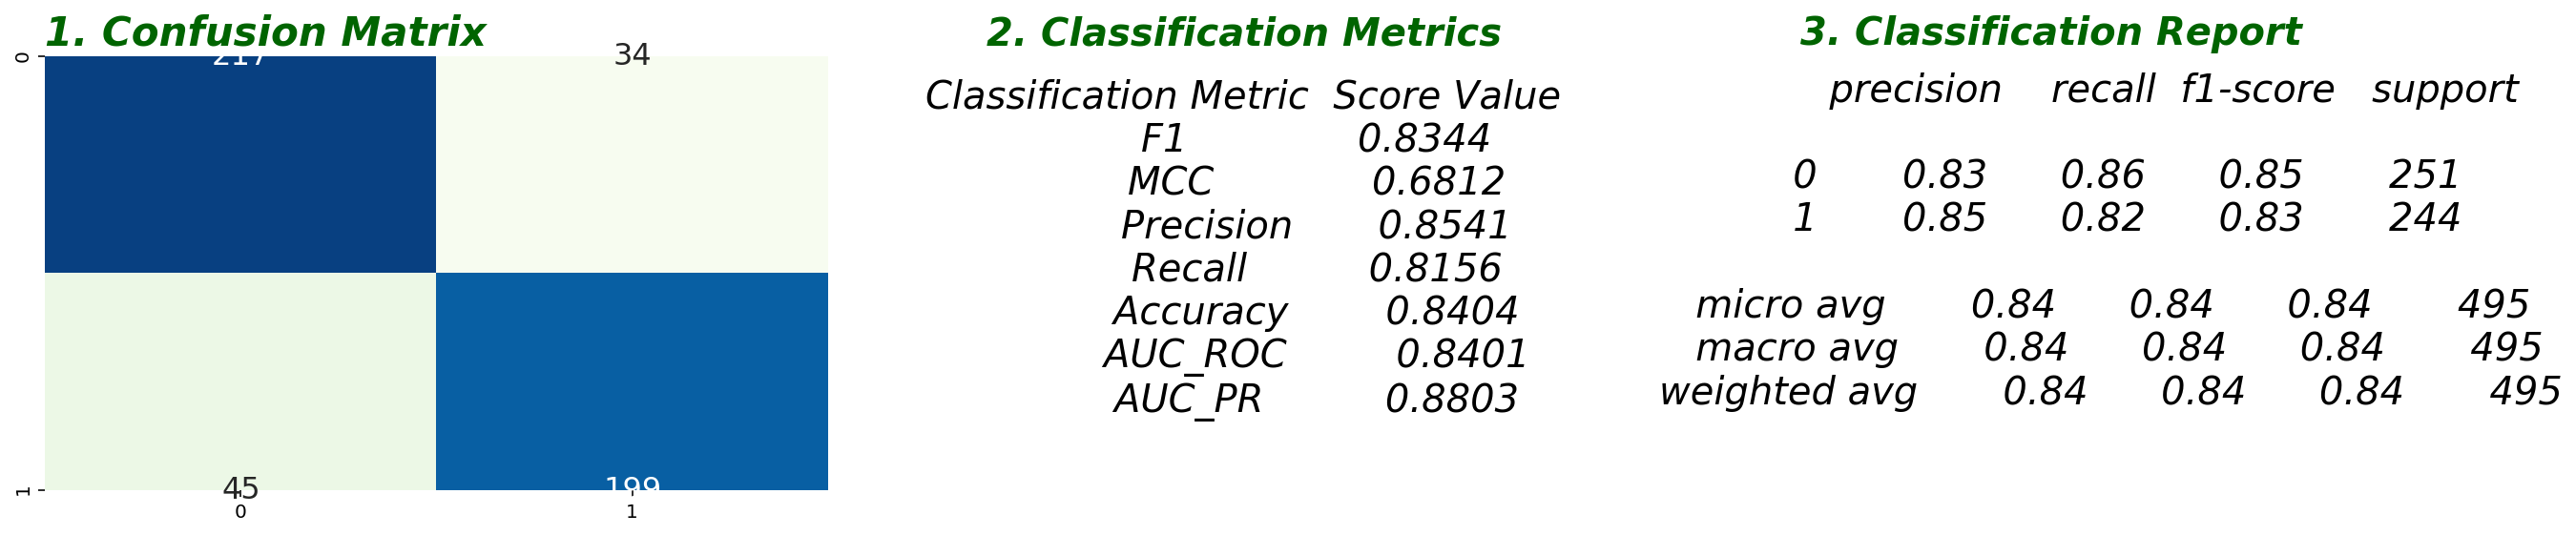

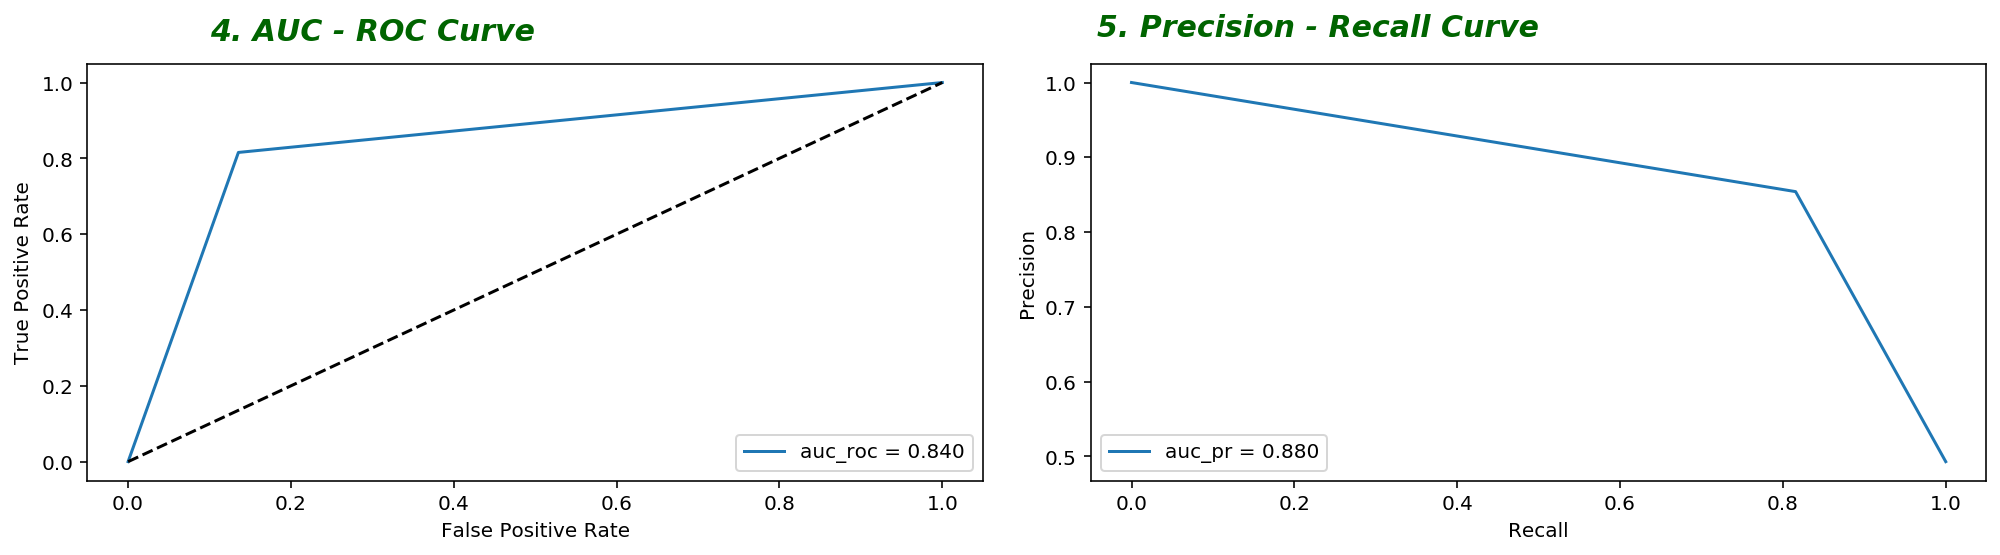

In [24]:
ValidateSkinCancerClassfier.Generate_Model_Test_Classification_Report(y_test, 
                                                                      y_preds_binary, 
                                                                      "Skin Cancer Detection Model")

<br>

***Model test results of 16 random test images...***

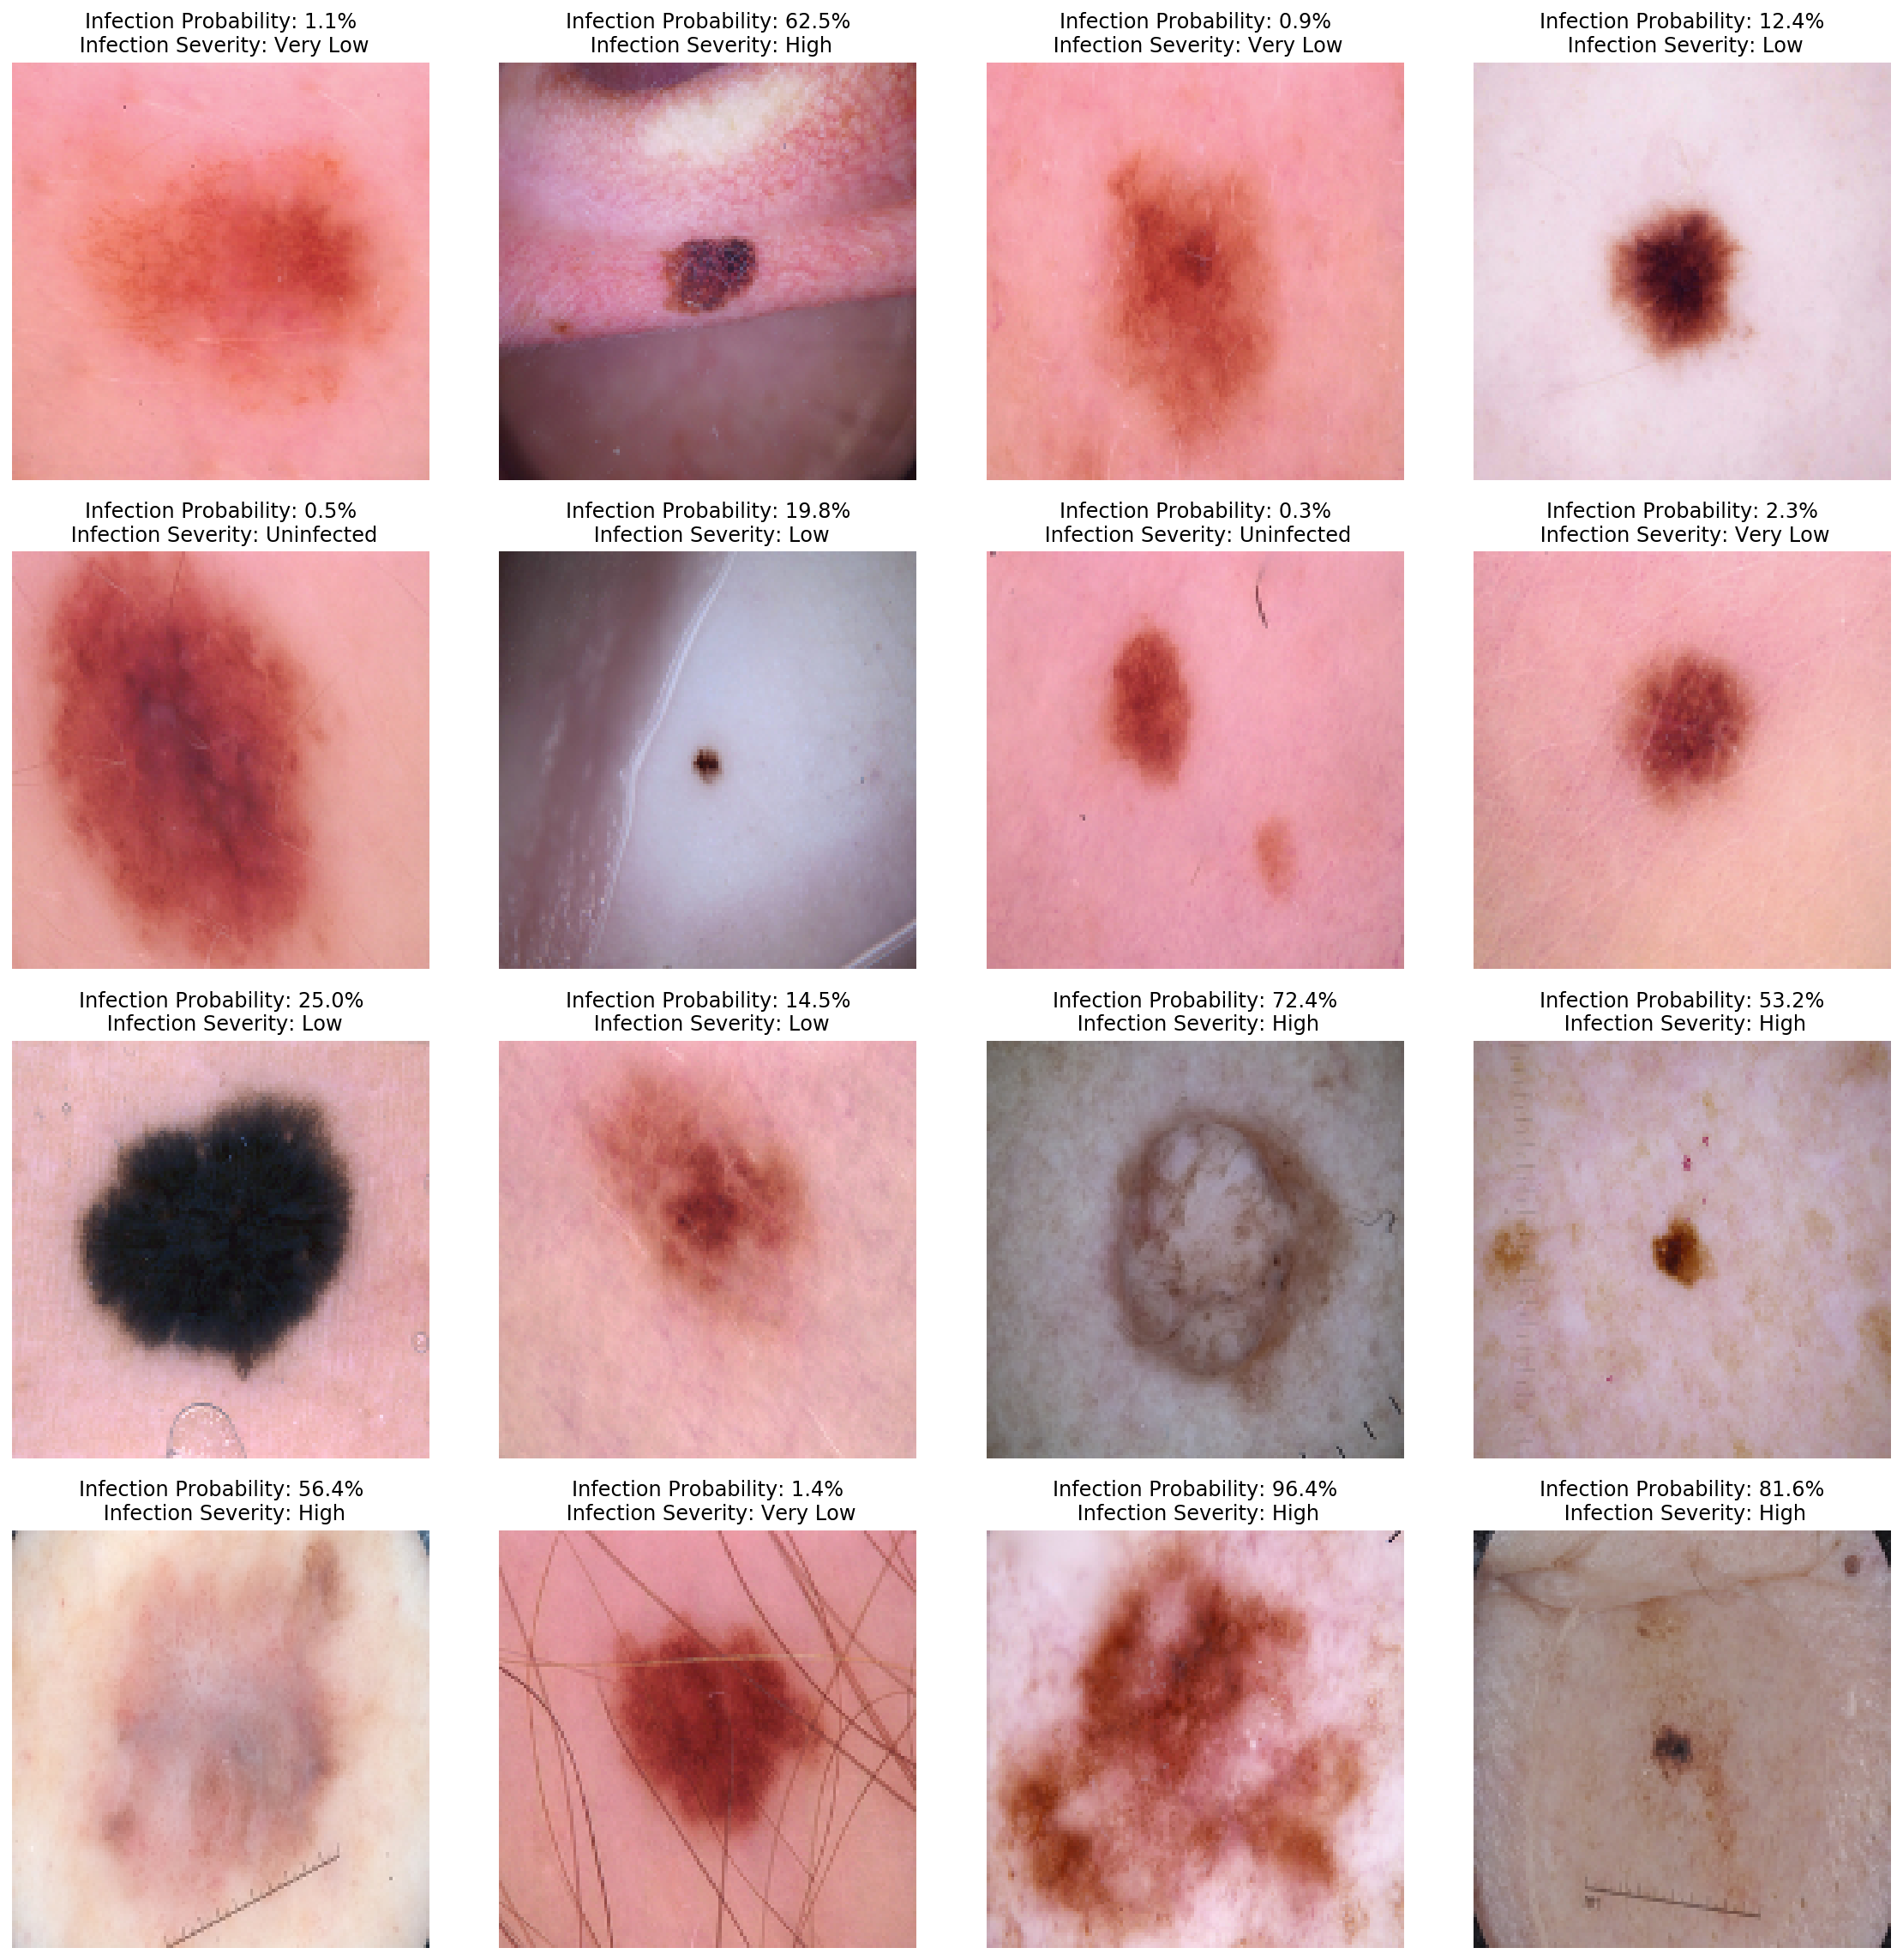

In [25]:
ValidateSkinCancerClassfier.PlotModelPredictionsOnRandomTestImages(X_test, y_test, y_preds_probability)

## Class Activation Maps - Viz

In [26]:
# initialize the CAM utility module..

from CAMUtility import CAMUtilities
cam = CAMUtilities(skinCancerDetectModel, "batch_normalization_3")

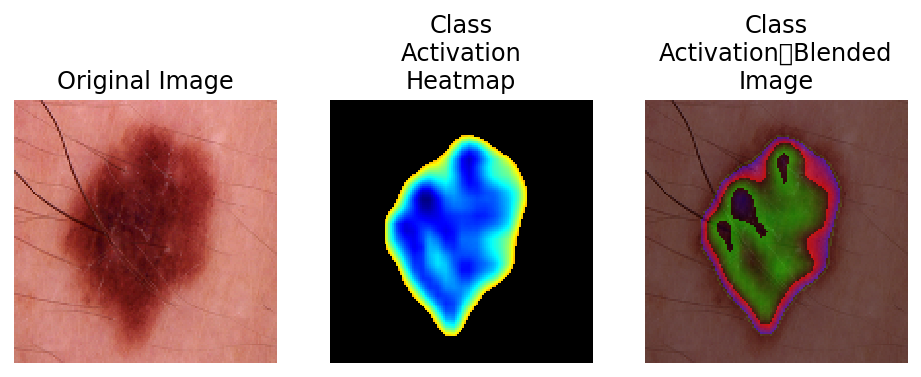

In [33]:
img = cv2.cvtColor(X_test[22], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# generate the heatmap
heatmap = cam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = cam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
cam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)

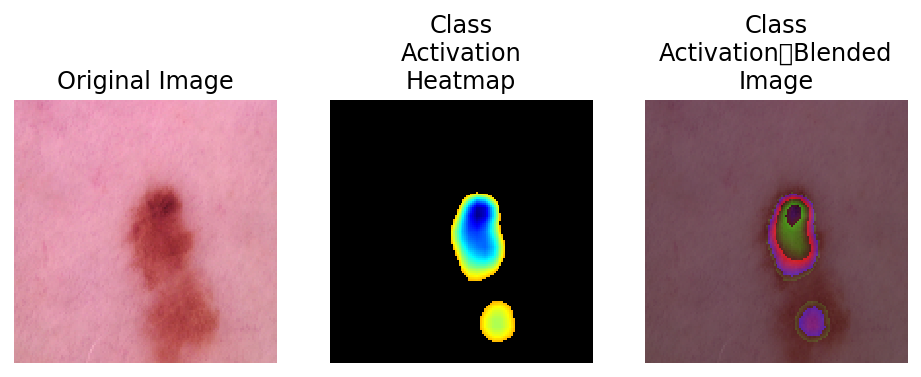

In [34]:
img = cv2.cvtColor(X_test[25], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# generate the heatmap
heatmap = cam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = cam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
cam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)

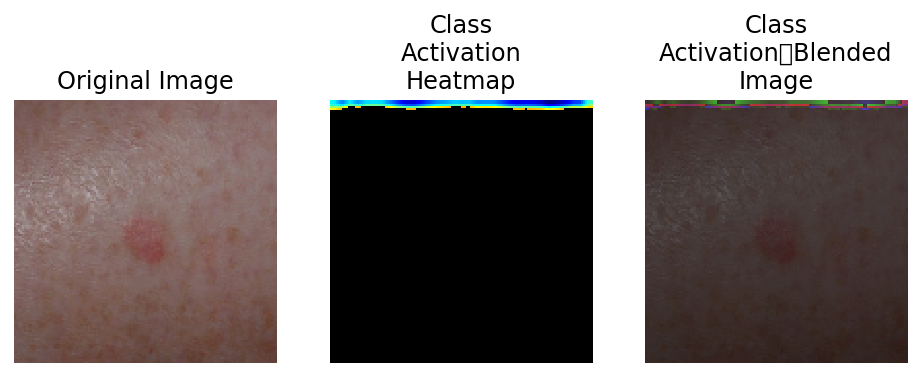

In [35]:
img = cv2.cvtColor(X_test[32], cv2.COLOR_BGR2RGB)
imgAsTensor = np.expand_dims(img, axis=0)

# generate the heatmap
heatmap = cam.compute_heatmap(imgAsTensor)

# generate the superimposed images and display
superImposedImg = cam.GetSuperImposedCAMImage(heatmap = heatmap, image = img)
cam.DisplaySuperImposedImages(image = img, heatmap = heatmap, superimposed_img = superImposedImg)